# 3. Machine Learning

## 3.1 Classifier Table

For the following section I am going to include some markdown notes to explain what I am doing, as they are a bit long.

In [145]:
df = df.drop(columns=['delivery_status','days_for_shipping_real','order_status'])

In [146]:
# This function I used to create the actual confusion matrix, which creates a subplot and each classifier is fitted to the training data,
# a confusion matrix is plotted for the validation set on a subplot axis and the title of each subplot is set to the corresponding classifier 
# name.
def plot_conf_matrix(names, classifiers, nrows, ncols, fig_a, fig_b):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fig_a, fig_b))
    i = 0
    for clf, ax in zip(classifiers, axes.flatten()):
        clf.fit(X_train, y_train)
        plot_confusion_matrix(clf, X_val, y_val, ax=ax)
        ax.title.set_text(names[i])
        i = i + 1       
    plt.tight_layout() 
    plt.show()
# I'm using this function to generate and display ROC curves for multiple classifiers, 
# showing their performance in distinguishing between classes, each ROC curve includes the classifier's 
# name and ROC AUC score for easy comparison
def roc_auc_curve(names, classifiers):   
    plt.figure(figsize=(12, 8))   
    for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)
        pred_proba = clf.predict_proba(X_val)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_val, pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=3, label= name +' ROC curve (area = %0.2f)' % (roc_auc))
        plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic (ROC) curves', fontsize=20)
        plt.legend(loc="lower right")

In [147]:
# Just setting the function to label encode cat features based on train only
def label_encode_cat_features(train, test, cat_features):
    for feature in cat_features:
        le = LabelEncoder()
        train[feature] = le.fit_transform(train[feature])
        # Here I'm dealing with some unseen categories in the test set by using np.where and defaulting to -1 for unknwn labels
        test[feature] = test[feature].map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)
    return train, test

# I'm setting the seed to 0 now so I don't have to keep setting the random state for each classifier
seed = 0

# Usin only 50% of my data
df_sample = df.sample(frac=0.5, random_state=seed)

# Im splitting my X and y variables
X = df_sample.drop('late_delivery_risk', axis=1)
y = df_sample['late_delivery_risk']

# Splitting into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=seed)

# Define your categorical features
cat_feats = ['type', 'category_name', 'customer_city', 'customer_country',
             'customer_segment', 'customer_state', 'department_name', 'market', 'order_city',
             'order_country', 'order_region', 'order_state',
             'product_name', 'shipping_mode', 'order_date', 'shipping_date']

# Perform label encoding after splitting (train and validation encoded separately)
X_train, X_val = label_encode_cat_features(X_train, X_val, cat_feats)

# Proceed with the rest of the code (classifier training, etc.)

# Laying down the classifier names
names = [
    'Nearest Neighbors',
    'Support Vectors',
    'Decision Tree',
    'Random Forest',
    'AdaBoost',
    'Gradient Boosting',
    'Quadratic DA',
    "Neural Net"
]

# Creating my classifiers and setting their random state to the previously defined seed so my results can be replicated
classifiers = [
    KNeighborsClassifier(2),
    SVC(probability=True, random_state=seed),
    DecisionTreeClassifier(random_state=seed),
    RandomForestClassifier(random_state=seed),
    AdaBoostClassifier(random_state=seed),
    GradientBoostingClassifier(random_state=seed),
    QuadraticDiscriminantAnalysis(),
    MLPClassifier(random_state=seed),
]

# This is the function to run my data on all the layed down classifiers. For each classifier I get them to:
# - Fit the classifier to the training data
# - predict on the validation set
# - calculate performance metrics: accuracy, recall, precision, F1 score, and ROC AUC
# - append the results to the list results
# I also added in an exception clause to return the error with the classifier name and and append NaN values for the broken model
def score_summary(names, classifiers):
    results = []
    for name, clf in zip(names, classifiers):
        try:
            clf.fit(X_train, y_train)
            pred = clf.predict(X_val)

            accuracy = accuracy_score(y_val, pred)
            recall = recall_score(y_val, pred)
            precision = precision_score(y_val, pred)
            f1 = f1_score(y_val, pred)

            roc_auc = float('nan')
            if hasattr(clf, "predict_proba"):
                pred_proba = clf.predict_proba(X_val)[:, 1]
                roc_auc = roc_auc_score(y_val, pred_proba)

            results.append({
                'Classifier': name,
                'Accuracy': accuracy,
                'Recall': recall,
                'Precision': precision,
                'F1': f1,
                'ROC_AUC': roc_auc
            })
        except Exception as e:
            print(f"Error with classifier {name}: {e}")
            results.append({
                'Classifier': name,
                'Accuracy': float('nan'),
                'Recall': float('nan'),
                'Precision': float('nan'),
                'F1': float('nan'),
                'ROC_AUC': float('nan')
            })

    return pd.DataFrame(results)

# This is the summary of all the results collected so far. It should be a grid in descending order of accuracy, The colour map is set to
# coolwarm for visualisations sake on Accuracy too, the other bars are given their own colour.
summary = score_summary(names, classifiers)
summary = summary.sort_values(by='Accuracy', ascending=False)

styled_summary = summary.style.background_gradient(cmap='coolwarm', subset=['Accuracy'])\
    .bar(subset=["ROC_AUC"], color='#6495ED')\
    .bar(subset=["Recall"], color='#ff355d')\
    .bar(subset=["Precision"], color='lightseagreen')\
    .bar(subset=["F1"], color='gold')

styled_summary

## 3.2 Random Forest

I'm setting the model, defining the parameters, then running the grid search, printing that out, then using the best params on my model and printing out the metrics and the classification report. I then do the same but run a k fold validation and instead of a grid search use specificaly chosen parameters. I run the same code blocks for 2 more models, adapting to them where necessary.

In [148]:
random_forest = RandomForestClassifier()
param_grid = {
    'n_estimators': [100, 300],            
    'max_depth': [10, 20, 30],             
    'min_samples_split': [2, 10],        
    'min_samples_leaf': [1, 5],          
    'criterion': ['gini', 'entropy'], 
}     

grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best Hyperparameters: {grid_search.best_params_}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val) 
accuracy = accuracy_score(y_val, y_pred) 
y_train_pred = best_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy}")
print(f"Validation Accuracy: {accuracy}")
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report(y_val, y_pred))

Best Hyperparameters: {'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Training Accuracy: 0.9994829598333653
Validation Accuracy: 0.7408375803235099
Accuracy: 0.7408375803235099
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.87      0.75     10031
           1       0.86      0.64      0.73     12534

    accuracy                           0.74     22565
   macro avg       0.76      0.75      0.74     22565
weighted avg       0.77      0.74      0.74     22565



In [149]:
best_hyperparameters = {
    'n_estimators': 200,            
    'max_depth': 15,             
    'min_samples_split': 10,        
    'min_samples_leaf': 4,          
    'criterion': 'gini', 
}

random_forest = RandomForestClassifier(**best_hyperparameters)

kf = KFold(n_splits=5, shuffle=True, random_state=0)
cv_scores = cross_val_score(random_forest, X_train, y_train, cv=kf, scoring='accuracy', n_jobs=-1)

print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean()}")
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_val)
y_train_pred = random_forest.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_pred)
print(f"Training Accuracy: {train_accuracy}")
print(f"Validation Accuracy: {val_accuracy}")
print("Validation Classification Report:\n", classification_report(y_val, y_pred))

Cross-Validation Scores: [0.6974 0.7063 0.7009 0.7056 0.7003]
Mean Cross-Validation Accuracy: 0.7020962537043967
Training Accuracy: 0.7355708862068456
Validation Accuracy: 0.7015732328827831
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.86      0.72     10031
           1       0.84      0.58      0.68     12534

    accuracy                           0.70     22565
   macro avg       0.73      0.72      0.70     22565
weighted avg       0.74      0.70      0.70     22565



## 3.3 KNN

In [150]:
knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [5, 10, 20],      
    'weights': ['uniform', 'distance'],  
    'algorithm': ['auto', 'ball_tree'], 
    'leaf_size': [30, 40],
    'p': [1, 2]                     
}

grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best Hyperparameters: {grid_search.best_params_}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
y_train_pred = best_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy}")
print(f"Validation Accuracy: {accuracy}")
print("Classification Report:\n", classification_report(y_val, y_pred))

Best Hyperparameters: {'algorithm': 'auto', 'leaf_size': 30, 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Training Accuracy: 1.0
Validation Accuracy: 0.7712829603368048
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.76      0.75     10031
           1       0.80      0.78      0.79     12534

    accuracy                           0.77     22565
   macro avg       0.77      0.77      0.77     22565
weighted avg       0.77      0.77      0.77     22565



In [151]:
best_hyperparameters = {
    'algorithm': 'auto',
    'leaf_size': 30,
    'n_neighbors': 8,
    'p': 2,
    'weights': 'uniform'
}

knn_model = KNeighborsClassifier(**best_hyperparameters)

kf = KFold(n_splits=5, shuffle=True, random_state=0)
cv_scores = cross_val_score(knn_model, X_train, y_train, cv=kf, scoring='accuracy', n_jobs=-1)
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean()}")

knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_val)
y_train_pred = knn_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_pred)
print(f"Training Accuracy: {train_accuracy}")
print(f"Validation Accuracy: {val_accuracy}")
print("Validation Classification Report:\n", classification_report(y_val, y_pred))

Cross-Validation Scores: [0.5909 0.5905 0.5949 0.588  0.586 ]
Mean Cross-Validation Accuracy: 0.5900609207276766
Training Accuracy: 0.7162188113985198
Validation Accuracy: 0.6031464657655662
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.67      0.60     10031
           1       0.67      0.55      0.61     12534

    accuracy                           0.60     22565
   macro avg       0.61      0.61      0.60     22565
weighted avg       0.62      0.60      0.60     22565



## 3.4 XGBoost

In [152]:
xgb_model = xgb.XGBClassifier(eval_metric='logloss') 

param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

print(f"Best Hyperparameters: {grid_search.best_params_}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
y_train_pred = best_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy}")
print(f"Validation Accuracy: {accuracy}")
print("Validation Classification Report:\n", classification_report(y_val, y_pred))

Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 500, 'subsample': 1.0}
Training Accuracy: 0.9980647925191675
Validation Accuracy: 0.8462663416795922
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.94      0.85     10031
           1       0.94      0.77      0.85     12534

    accuracy                           0.85     22565
   macro avg       0.85      0.86      0.85     22565
weighted avg       0.86      0.85      0.85     22565



## 3.5 Model Interpretation 

In [153]:
best_hyperparameters = {
    'colsample_bytree': 1.0,
    'learning_rate': 0.1,
    'max_depth': 8,
    'n_estimators': 300,
    'subsample': 1.0,
}

xgb_model = xgb.XGBClassifier(**best_hyperparameters)

kf = KFold(n_splits=5, shuffle=True, random_state=0)

cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=kf, scoring='accuracy', n_jobs=-1)

print(f"K-Fold Cross-Validation Scores: {cv_scores}")
print(f"Mean K-Fold Accuracy: {cv_scores.mean()}")

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_val)

train_accuracy = accuracy_score(y_train, xgb_model.predict(X_train))
val_accuracy = accuracy_score(y_val, y_pred)

print(f"Training Accuracy: {train_accuracy}")
print(f"Validation Accuracy: {val_accuracy}")
print("Validation Classification Report:\n", classification_report(y_val, y_pred))

K-Fold Cross-Validation Scores: [0.8683 0.8779 0.8832 0.8753 0.8744]
Mean K-Fold Accuracy: 0.8758216964542205
Training Accuracy: 0.9624333387499446
Validation Accuracy: 0.8193219587857301
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.92      0.82     10031
           1       0.92      0.74      0.82     12534

    accuracy                           0.82     22565
   macro avg       0.83      0.83      0.82     22565
weighted avg       0.84      0.82      0.82     22565



Here I'm using XGBoosts built in feature importance tool and create a DataFrame with the top 10 features ranked by their importance in each case. The results then are visualized with bar charts for both weight and gain, then I add a table of the results at the end

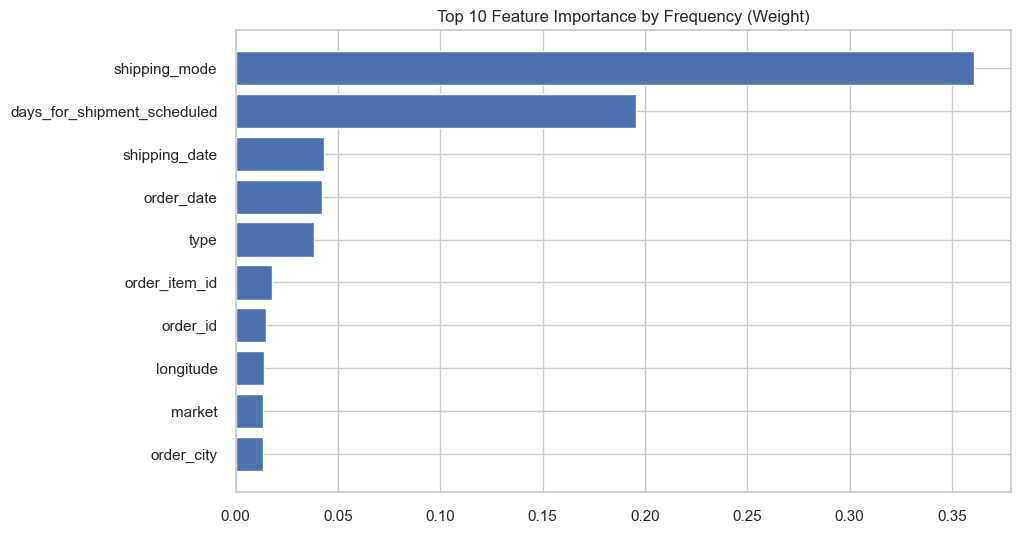

<Figure size 1000x600 with 0 Axes>

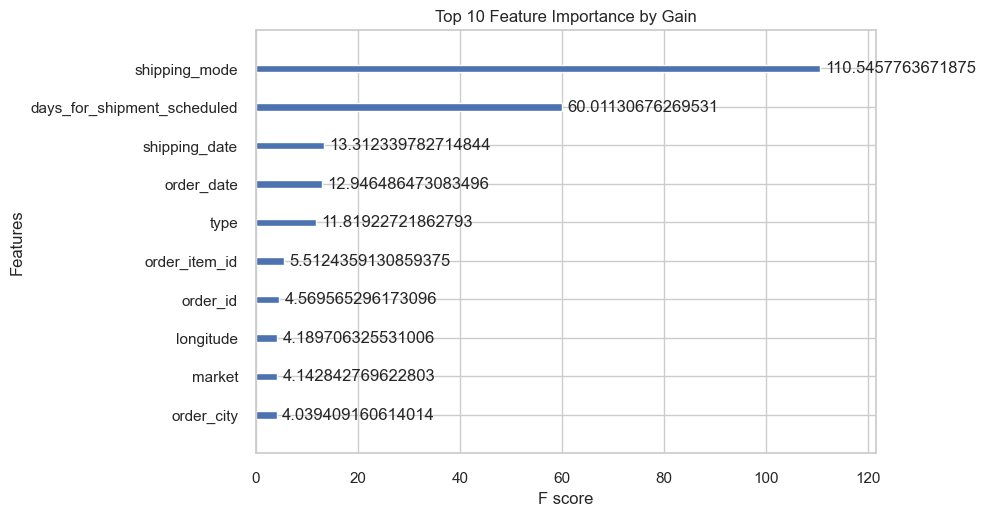

Top 10 Feature Importance (Weight vs Gain):
                        Feature  Importance (Weight)  Importance (Gain)
0  days_for_shipment_scheduled             0.195722          60.011307
1                    longitude             0.013664           4.189706
2                       market             0.013512           4.142843
3                   order_city             0.013174           4.039409
4                   order_date             0.042224          12.946486
5                     order_id             0.014903           4.569565
6                order_item_id             0.017978           5.512436
7                shipping_date             0.043417          13.312340
8                shipping_mode             0.360536         110.545776
9                         type             0.038547          11.819227


In [154]:
feature_importances_weight = xgb_model.feature_importances_

feature_names = X_train.columns 
importance_weight_df = pd.DataFrame({'Feature': feature_names, 'Importance (Weight)': feature_importances_weight})

importance_weight_df = importance_weight_df.sort_values(by='Importance (Weight)', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(importance_weight_df['Feature'], importance_weight_df['Importance (Weight)'])
plt.title('Top 10 Feature Importance by Frequency (Weight)')
plt.gca().invert_yaxis()  
plt.show()

plt.figure(figsize=(10, 6))
plot_importance(xgb_model, importance_type='gain', max_num_features=10) 
plt.title('Top 10 Feature Importance by Gain')
plt.show()

importance_gain_dict = xgb_model.get_booster().get_score(importance_type='gain')
importance_gain_df = pd.DataFrame(list(importance_gain_dict.items()), columns=['Feature', 'Importance (Gain)'])

importance_gain_df = importance_gain_df.sort_values(by='Importance (Gain)', ascending=False).head(10)
importance_df_combined = pd.merge(importance_weight_df, importance_gain_df, on='Feature', how='outer')

print("Top 10 Feature Importance (Weight vs Gain):\n", importance_df_combined)

Here I'm using the LIME explainer 

Here I creatued a LimeTabularExplainer with the training data and feature names. I then picked a random instance from the validation set to explain, the explanation is then displayed in a notebook, printed as a list, and saved to an HTML file for reference

In [155]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values,
                                                        feature_names=X_train.columns,
                                                        class_names=['Class 0', 'Class 1'],
                                                        mode='classification')
instance_to_explain = X_val.iloc[0].values
lime_explanation = lime_explainer.explain_instance(instance_to_explain,
                                                   xgb_model.predict_proba, 
                                                   num_features=10)
lime_explanation.show_in_notebook()
print(lime_explanation.as_list())
lime_explanation.save_to_file('lime_explanation.html')

[('2.00 < days_for_shipment_scheduled <= 4.00', -0.19153136015027425), ('shipping_date > 32120.00', 0.1851652284253448), ('order_date > 32819.00', -0.11804917049902819), ('2.00 < shipping_mode <= 3.00', -0.09200441668884866), ('type <= 1.00', 0.026802507035258463), ('order_item_total > 247.50', -0.01989626638176983), ('order_item_product_price > 199.99', 0.0178284198252829), ('17814.00 < order_id <= 36088.00', 0.01665155764763827), ('sales > 299.95', 0.016008525350194643), ('892.00 < order_city <= 1848.00', 0.013964277156342532)]


Here I'm just reversing the label encoding to understand the LIME results

In [156]:
le_type = LabelEncoder()
le_type.fit(df['type'])
original_type = le_type.inverse_transform([3])
print(f"Original value for type 3: {original_type[0]}")

le_shipping_date = LabelEncoder()
le_shipping_date.fit(df['shipping_date'])
original_shipping_date = le_shipping_date.inverse_transform([37400])
print(f"Original value for shipping_date 37400: {original_shipping_date[0]}")

le_order_date = LabelEncoder()
le_order_date.fit(df['order_date'])
original_order_date = le_order_date.inverse_transform([38400])
print(f"Original value for order_date 38400: {original_order_date[0]}")

le_shipping_mode = LabelEncoder()
le_shipping_mode.fit(df['shipping_mode'])
original_shipping_mode = le_shipping_mode.inverse_transform([3])
print(f"Original value for shipping_mode 3: {original_shipping_mode[0]}")

le_category_id = LabelEncoder()
le_category_id.fit(df['category_id'])
original_category_id = le_category_id.inverse_transform([43])
print(f"Original value for category_id 43: {original_category_id[0]}")

Original value for type 3: TRANSFER
Original value for shipping_date 37400: 4/4/2016 16:42
Original value for order_date 38400: 4/3/2017 6:43
Original value for shipping_mode 3: Standard Class
Original value for category_id 43: 69


Running a manual visual barchart to compare my model results

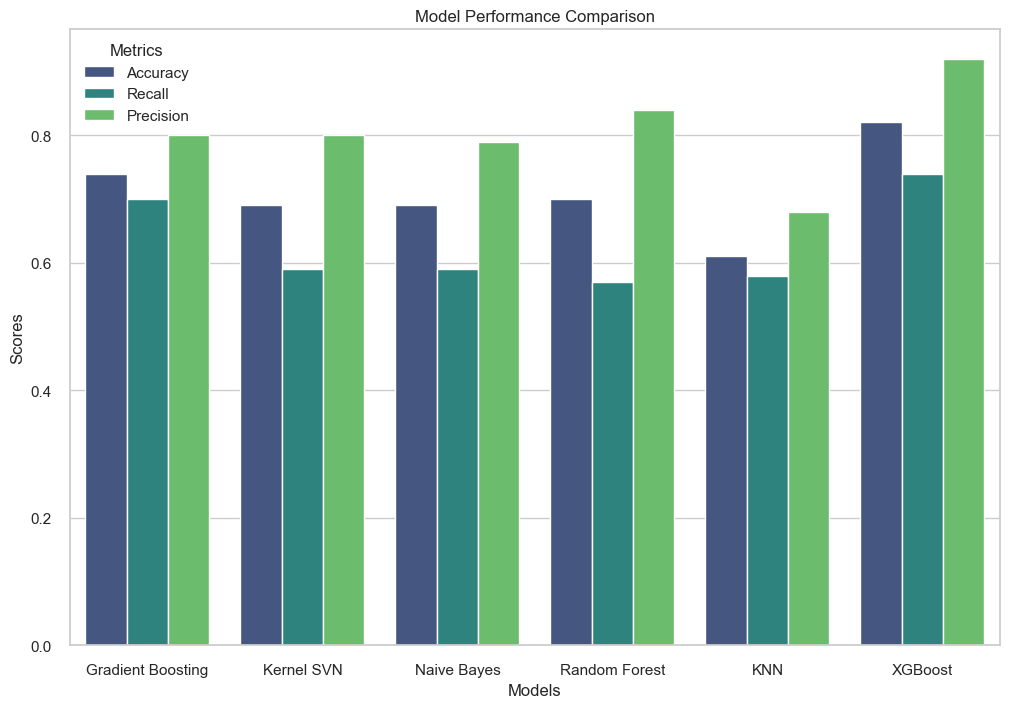

In [158]:
models = ['Gradient Boosting', 'Kernel SVN', 'Naive Bayes', 'Random Forest', 'KNN', 'XGBoost']
accuracy = [0.74, 0.69, 0.69, 0.70, 0.61, 0.82]
recall = [0.7, 0.59, 0.59, 0.57, 0.58, 0.74]
precision = [0.8, 0.8, 0.79, 0.84, 0.68, 0.92]

data__for_models = {
    'Model': models * 3,
    'Score': accuracy + recall + precision,
    'Metric': ['Accuracy'] * 6 + ['Recall'] * 6 + ['Precision'] * 6
}

df_for_final_model = pd.DataFrame(data__for_models)
plt.figure(figsize=(12, 8))
palette = sns.color_palette('viridis', 3)
barplot = sns.barplot(data=df_for_final_model, x='Model', y='Score', hue='Metric', palette=palette, dodge=True)

plt.title('Model Performance Comparison')
plt.xlabel('Models')
plt.ylabel('Scores')

handles, labels = barplot.get_legend_handles_labels()
plt.legend(handles, ['Accuracy', 'Recall', 'Precision'], title='Metrics')

plt.show()